In [3]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Ignore warnings
warnings.filterwarnings("ignore")

In [4]:
# Initialize the CNN
classifier = Sequential()

# Convolutional layers with increasing filters
classifier.add(Conv2D(64, (3, 3), input_shape=(128, 128, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(256, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(512, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the pooled feature maps
classifier.add(Flatten())

# Fully connected layers with dropout for regularization
classifier.add(Dense(units=256, activation='relu'))
classifier.add(Dropout(0.5))  # Dropout layer to prevent overfitting

classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
classifier.add(Dense(units=3, activation='softmax'))

# Compile the CNN with Adam optimizer and categorical cross-entropy loss
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Define the data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Define the data augmentation for the testing/validation sets
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Define the training set
training_set = train_datagen.flow_from_directory(
    'Train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

# Define the validation set
valid_set = test_datagen.flow_from_directory(
    'Valid',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

# Define the testing set
test_set = test_datagen.flow_from_directory(
    'Test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # Shuffle is False to keep labels intact for evaluation


Found 1169 images belonging to 3 classes.
Found 689 images belonging to 3 classes.
Found 678 images belonging to 3 classes.


In [8]:
# Callbacks: Early Stopping and Model Checkpoint
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [10]:
# Train the model
history = classifier.fit(
    training_set,
    epochs=50,
    validation_data=valid_set,
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)


Epoch 1/50
37/37 [==============================] - 9s 245ms/step - loss: 0.8495 - accuracy: 0.5783 - val_loss: 0.7721 - val_accuracy: 0.6662
Epoch 2/50
37/37 [==============================] - 9s 248ms/step - loss: 0.7899 - accuracy: 0.6433 - val_loss: 0.7011 - val_accuracy: 0.6981
Epoch 3/50
37/37 [==============================] - 9s 247ms/step - loss: 0.7270 - accuracy: 0.6689 - val_loss: 0.6583 - val_accuracy: 0.6909
Epoch 4/50
37/37 [==============================] - 9s 241ms/step - loss: 0.7019 - accuracy: 0.6852 - val_loss: 0.6361 - val_accuracy: 0.6938
Epoch 5/50
37/37 [==============================] - 9s 253ms/step - loss: 0.6564 - accuracy: 0.6903 - val_loss: 0.5860 - val_accuracy: 0.6996
Epoch 6/50
37/37 [==============================] - 9s 244ms/step - loss: 0.6471 - accuracy: 0.6989 - val_loss: 0.6347 - val_accuracy: 0.6792
Epoch 7/50
37/37 [==============================] - 9s 245ms/step - loss: 0.6191 - accuracy: 0.7015 - val_loss: 0.5769 - val_accuracy: 0.7228
Epoch 

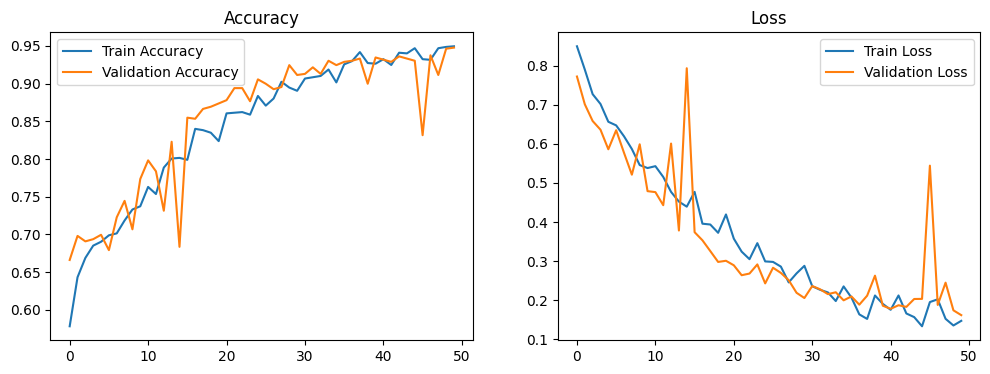

In [11]:
# Plotting the training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = classifier.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy:.4f}")

22/22 [==============================] - 3s 110ms/step - loss: 0.2111 - accuracy: 0.9292
Test Accuracy: 0.9292


In [13]:
# Generate predictions and classification report
y_pred = classifier.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes


22/22 [==============================] - 3s 113ms/step


In [14]:
# Classification Report
class_labels = list(test_set.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

      benign       0.91      0.97      0.94       382
   malignant       0.95      0.83      0.89       179
      normal       0.95      0.94      0.94       117

    accuracy                           0.93       678
   macro avg       0.94      0.91      0.92       678
weighted avg       0.93      0.93      0.93       678



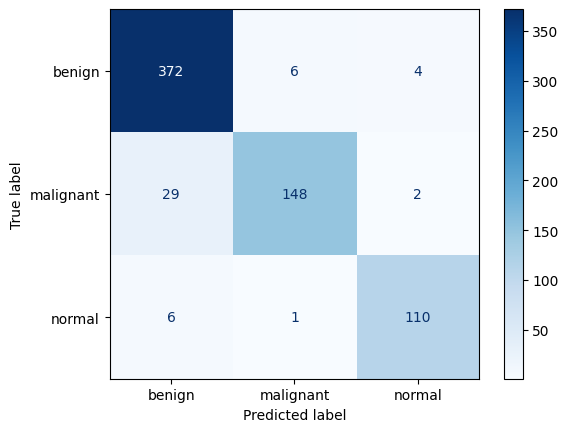

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [16]:
# Image Classification (Example)
def classify_image(image_path):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = classifier.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.show()


In [ ]:
# Example usage of classify_image function
classify_image("image path")